In [1]:
import csv
import pickle
import datetime
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png','retina'}

In [3]:
def import_data():
    df = pd.read_csv('final_df.csv')
    df = df.iloc[:,1:]
    
    return df

In [4]:
def fulldf(df):
    
    df.snowfall = df.snowfall.replace(["T","  T"],0.05)
    df.preciptotal = df.preciptotal.replace(["T","  T"],0.005)
    df.depart = pd.to_numeric(df.depart, errors='coerce')
    
    df = type_change_numeric(df,[ 'store_nbr', 'item_nbr', 'units', 'station_nbr', 'tmax', 'tmin',
       'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'avgspeed', 'resultspeed', 'resultdir' ])
    df['date'] = pd.to_datetime(df['date'])
                                   
    
    df["day_of_year"] = df['date'].dt.dayofyear
    df["year"] = df['date'].dt.year
    df["month"] = df["date"].dt.month
    
    
    for idx in range(5, 8):
        df.iloc[:,idx].fillna(df.groupby(["day_of_year","store_nbr"])[df.columns[idx]].\
                              transform('mean'), inplace=True)

    for idx in range(16, 23):
        df.iloc[:,idx].fillna(df.groupby(["day_of_year","store_nbr"])[df.columns[idx]].\
                              transform('mean'), inplace=True)
    add_depart1(df)
    
    return df

# for column in item37.columns:
#     item37[column].interpolate()

In [5]:
def type_change_numeric(df, ls = []): 
    #ls에 있는 column name은 numeric형으로 바꾸지 않는다.
    cols = df.columns
    for i in cols:
        if i in ls:
            #df = df.replace(["M",None], '')
            df.snowfall = df.snowfall.replace(["T","  T"],0.05)
            df.preciptotal = df.preciptotal.replace(["T","  T"],0.005)
            df[i] = pd.to_numeric(df[i], errors='coerce')
        
    return df

In [6]:
def add_depart1(x):
    x.depart.fillna(x.tavg - x.groupby(["day_of_year","store_nbr"])["tavg"].transform('mean'),inplace = True)
    x.depart = x.depart.round(2)
    return x.sort_values(["store_nbr","date","item_nbr"])

In [7]:
def reorder_df(df):
    #Column 정렬 (y값을 마지막으로 ) 후 FG+ -> FG2 변환 (formula에 인식시키기위해 )
    new_order =  ['date', 'store_nbr', 'item_nbr', 'station_nbr', 'tmax', 'tmin',
       'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',  'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'avgspeed', 'resultspeed', 'TS', 'GR', 'RA', 'DZ', 'SN',
       'SG', 'GS', 'PL', 'FG+', 'FG', 'BR', 'UP', 'HZ', 'FU', 'DU', 'SQ', 'FZ',
       'MI', 'PR', 'BC', 'BL', 'VC', 'day_of_year', 'year', 'month', 'units' ]
    df = df[new_order]
    df.columns = ['date', 'store_nbr', 'item_nbr', 'station_nbr', 'tmax', 'tmin',
       'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'avgspeed', 'resultspeed', 'TS', 'GR', 'RA', 'DZ', 'SN',
       'SG', 'GS', 'PL', 'FG2', 'FG', 'BR', 'UP', 'HZ', 'FU', 'DU', 'SQ', 'FZ',
       'MI', 'PR', 'BC', 'BL', 'VC', 'day_of_year', 'year', 'month', 'units' ]
    
    return df

In [8]:
def add_cat_columns(df):
    df['date'] = pd.to_datetime(df['date'])
#     df['sunrise'] = pd.to_datetime(df['sunrise'], format='%H%M')
#     df['sunset'] = pd.to_datetime(df['sunset'], format='%H%M')

    blackfriday = ["2012-11-21","2012-11-22","2012-11-23", "2012-11-24","2012-11-25",
              "2013-11-27","2013-11-28", "2013-11-29","2013-11-30","2013-11-31",
              "2014-11-26", "2014-11-27", "2014-11-28","2014-11-29","2014-11-30"]
    df["week_day_name"] = df['date'].dt.weekday_name
    df['weekend'] = False
    df.weekend[df['week_day_name'] == 'Sunday'] = True
    df.weekend[df['week_day_name'] == 'Saturday'] = True
    df.weekend[df['week_day_name'] == 'Friday'] = True
    df["is_blackfriday"] = df.date.apply(lambda x : str(x)[:10] in blackfriday).astype(int)
    
    df['hardrain'] = [(((4 if i > 8 else 3) if i > 6 else 2) if i > 1 else 1) if i > 0 else 0 for i in df['preciptotal']]
    # rain 1 snow 2
    # 득정조건열 추가 ()
    df['hardsnow'] = [(( 3 if i > 3.5 else 2) if i > 1 else 1) if i > 0 else 0 for i in df['snowfall']]
    
    df['log_units'] = df.units.apply(lambda x: np.log(x + 1)).astype(float)
    return df

In [9]:
def df_sampling(df):
    new_order = ['date', 'store_nbr', 'item_nbr', 'station_nbr', 'tmax', 'tmin', 'tavg',
       'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel', 'avgspeed',
       'resultspeed', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS',
       'PL', 'FG2', 'FG', 'BR', 'UP', 'HZ', 'FU', 'DU', 'SQ', 'FZ', 'MI', 'PR',
       'BC', 'BL', 'VC', 'day_of_year', 'year', 'month', 
       'week_day_name', 'weekend', 'is_blackfriday', 'hardrain', 'hardsnow',
       'log_units', 'units' ]
    
    df = df[new_order]
    
    X, y = df.iloc[:,:-1], df.units
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2018)
    
    train = pd.concat([X_train, y_train] ,axis = 1)
    train = train.sort_values(by=['date', 'store_nbr', 'item_nbr']).reset_index(drop= True)
    X_test = X_test.sort_index()
    y_train = y_train.sort_index()
    y_test = y_test.sort_index()
    
    return train, y_train,  X_test ,y_test
   

In [10]:
data = import_data()
data_t = fulldf(data)
data_t = reorder_df(data_t)
data_t  = add_cat_columns(data_t)

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [11]:
del data_t['snowfall']
data_t = data_t.dropna()

In [12]:
train0, y_train, X_test, y_test = df_sampling(data_t)
train = sm.add_constant(train0)

In [13]:
model_OLS = sm.OLS.from_formula("log_units ~  C(store_nbr) + C(item_nbr) + scale(preciptotal) + C(weekend) + C(month) + C(year) + C(is_blackfriday) + 0" , data = train)
# model_OLS = sm.OLS.from_formula("log_units ~  C(store_nbr) + C(item_nbr) + scale(preciptotal) + C(weekend) + C(month) + C(year) + C(is_blackfriday) + 0" , data = train)
results_OLS = model_OLS.fit()
print(results_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     2362.
Date:                Fri, 06 Jul 2018   Prob (F-statistic):               0.00
Time:                        21:12:43   Log-Likelihood:            -1.8464e+05
No. Observations:              137120   AIC:                         3.696e+05
Df Residuals:                  136960   BIC:                         3.712e+05
Df Model:                         159                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
C(store_nbr)[1]            0

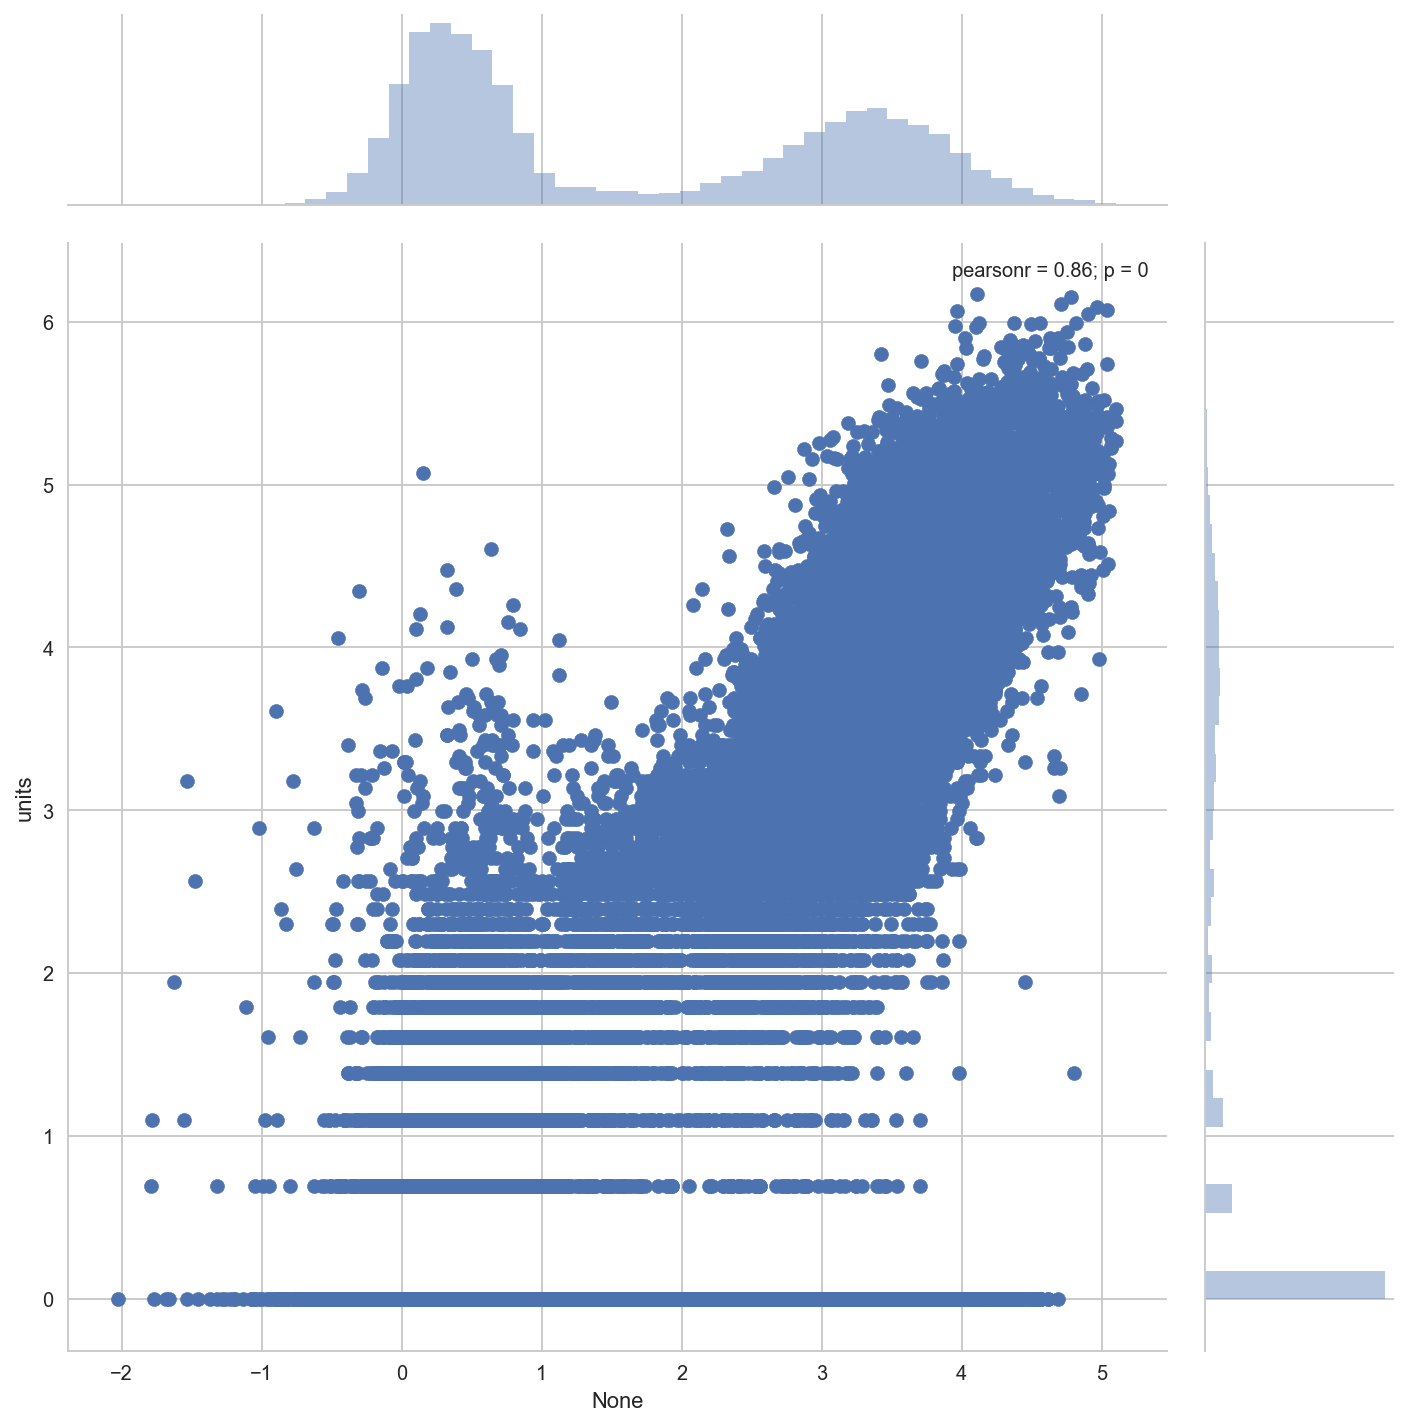

In [16]:
sns.jointplot(results_OLS.predict(X_test), np.log(y_test + 1), size = 10)
plt.show()

In [18]:
#교차검증

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

scores = np.zeros(10)
rand_st = 103

for i in range(1,len(scores)+1):
    print("교차검증", i ,"차 : ", end ="")
    
    X_train, X_test, y_train, y_test = train_test_split(data_t.iloc[:,1:],\
                                                        data_t.units, test_size=0.30, random_state=i*2018*rand_st)
    
    print("모델 생성중...", end = "")
    model = sm.OLS.from_formula("log_units ~  C(store_nbr) + C(item_nbr) + scale(I(preciptotal*2))+ C(weekend) + C(month) + C(year) + C(is_blackfriday) + 0" , data = train)
    # model_OLS = sm.OLS.from_formula("log_units ~  C(store_nbr) + C(item_nbr) + scale(preciptotal) + C(weekend) + C(month) + C(year) + C(is_blackfriday) + 0" , data = train)
    # # model = sm.Logit.from_formula(formula=formula, data=X_train)
    result = model.fit()
    y_pred = result.predict(X_test)
    
    print("완료! 채점중...", end ="")
    y_test2=np.log(y_test+1)
    scores[i-1] = r2_score(y_test2, y_pred)
    print(scores[i-1])

scores

교차검증 1 차 : 모델 생성중...완료! 채점중...0.73612522756
교차검증 2 차 : 모델 생성중...완료! 채점중...0.735058182197
교차검증 3 차 : 모델 생성중...완료! 채점중...0.732711435426
교차검증 4 차 : 모델 생성중...완료! 채점중...0.734371828335
교차검증 5 차 : 모델 생성중...완료! 채점중...0.738977381135
교차검증 6 차 : 모델 생성중...완료! 채점중...0.735592214565
교차검증 7 차 : 모델 생성중...완료! 채점중...0.739600568526
교차검증 8 차 : 모델 생성중...완료! 채점중...0.729258241716
교차검증 9 차 : 모델 생성중...완료! 채점중...0.73139233155
교차검증 10 차 : 모델 생성중...완료! 채점중...0.730450238278


array([ 0.73612523,  0.73505818,  0.73271144,  0.73437183,  0.73897738,
        0.73559221,  0.73960057,  0.72925824,  0.73139233,  0.73045024])